# Setup
We will be using TensorFlow 1.2 and Keras 2.0.4. Let's begin:

In [7]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

# Loading the data
The dataset we're going to use can be downloaded from Kaggle. It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [9]:
df = pd.read_csv("creditcard.csv")

In [11]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Exploration

In [12]:
df.shape

(284807, 31)

31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let's check for missing values

In [13]:
df.isnull().values.any()

False

C:\Users\kiransindam\AppData\Local\Temp\ipykernel_12476\2107955042.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


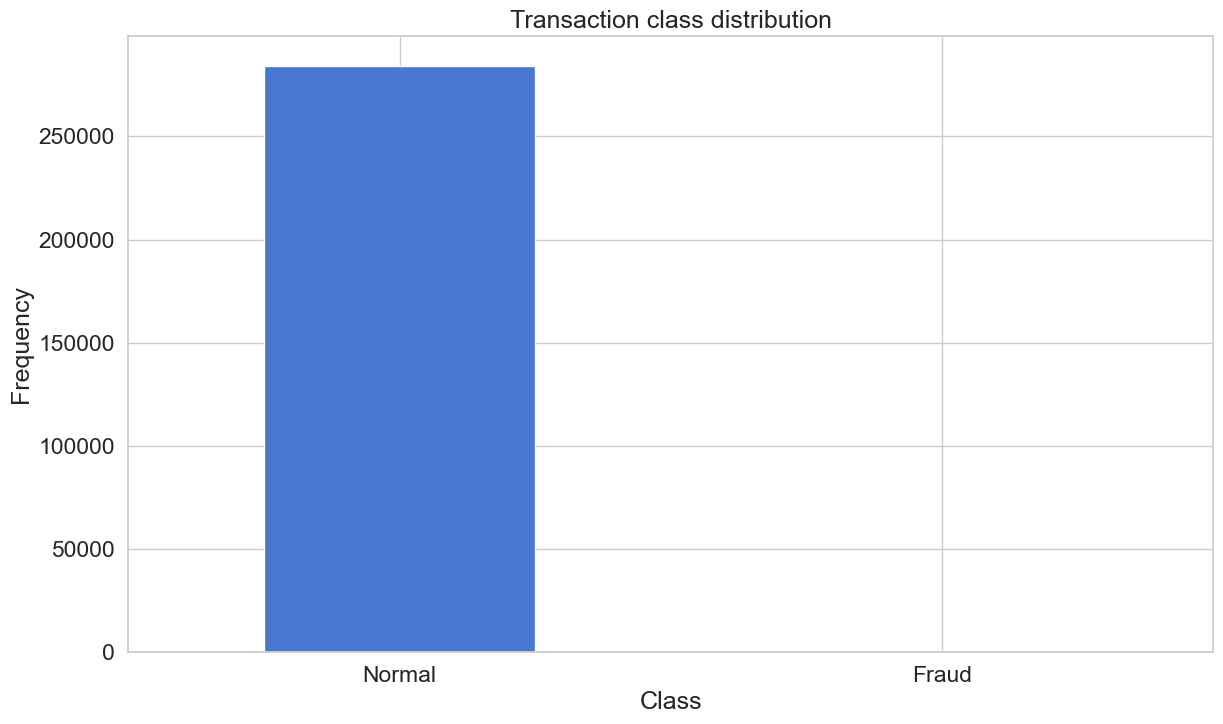

In [14]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [18]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [19]:
frauds.shape

(492, 31)

In [20]:
normal.shape

(284315, 31)

In [21]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [22]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

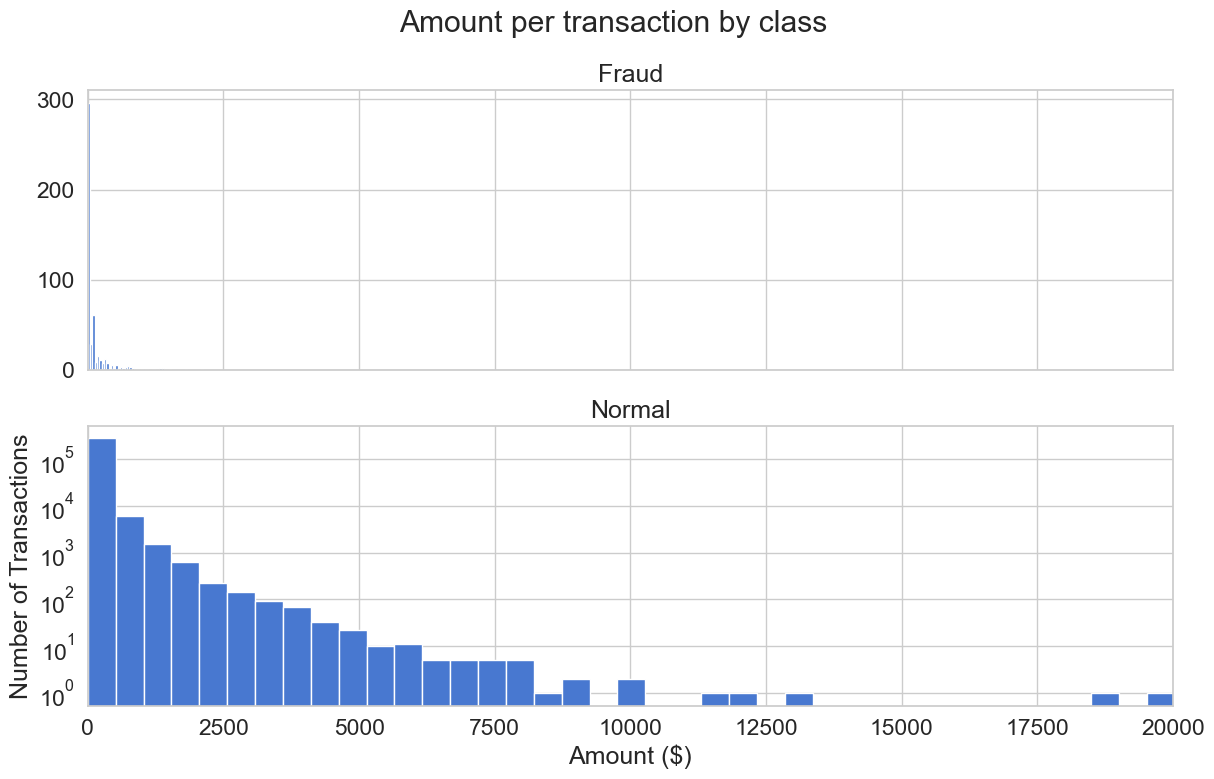

In [23]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

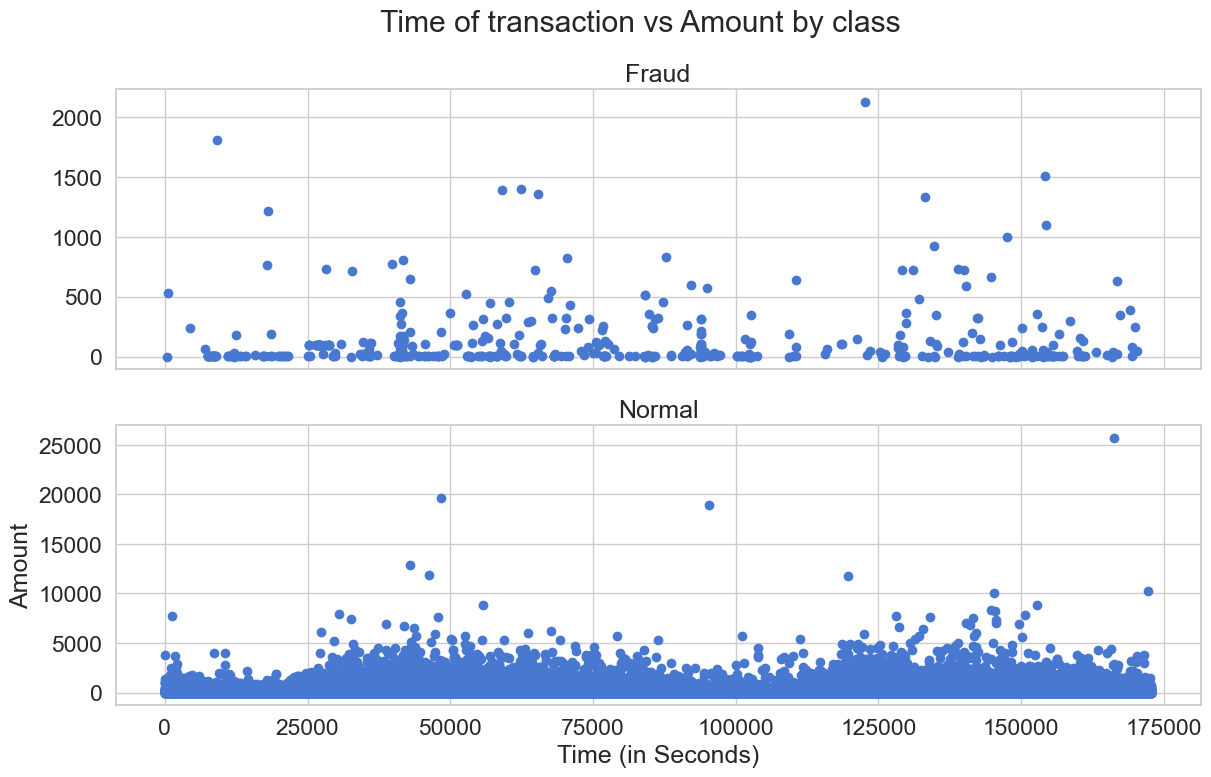

In [24]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

# Autoencoders
Autoencoders can seem quite bizarre at first. The job of those models is to predict the input, given that same input. Puzzling? Definitely was for me, the first time I heard it.

More specifically, let’s take a look at Autoencoder Neural Networks. This autoencoder tries to learn to approximate the following identity function:


While trying to do just that might sound trivial at first, it is important to note that we want to learn a compressed representation of the data, thus find structure. This can be done by limiting the number of hidden units in the model. Those kind of autoencoders are called undercomplete.

Here's a visual representation of what an Autoencoder might learn:

# Reconstruction error
We optimize the parameters of our Autoencoder model in such way that a special kind of error - reconstruction error is minimized. In practice, the traditional squared error is often used:


If you want to learn more about Autoencoders I highly recommend the following videos by Hugo Larochelle:

# Preparing the data
First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [25]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [26]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [27]:
X_train.shape

(227451, 29)

# Building the model
Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively. The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [28]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [29]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [30]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
7101/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5081 - loss: 0.8736

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.5082 - loss: 0.8735 - val_accuracy: 0.6640 - val_loss: 0.7894
Epoch 2/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6676 - loss: 0.7493

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.6676 - loss: 0.7493 - val_accuracy: 0.6644 - val_loss: 0.7734
Epoch 3/100
7095/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6622 - loss: 0.7220

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.6622 - loss: 0.7221 - val_accuracy: 0.6563 - val_loss: 0.7688
Epoch 4/100
7094/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6655 - loss: 0.7392

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.6655 - loss: 0.7391 - val_accuracy: 0.6592 - val_loss: 0.7631
Epoch 5/100
7096/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6667 - loss: 0.7256

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6667 - loss: 0.7256 - val_accuracy: 0.6632 - val_loss: 0.7610
Epoch 6/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6707 - loss: 0.7166

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.6707 - loss: 0.7166 - val_accuracy: 0.6756 - val_loss: 0.7587
Epoch 7/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.6726 - loss: 0.7685 - val_accuracy: 0.6618 - val_loss: 0.7634
Epoch 8/100
7098/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6768 - loss: 0.7240

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.6768 - loss: 0.7240 - val_accuracy: 0.6829 - val_loss: 0.7575
Epoch 9/100
7104/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6782 - loss: 0.7365

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.6782 - loss: 0.7365 - val_accuracy: 0.6737 - val_loss: 0.7566
Epoch 10/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6813 - loss: 0.7185 - val_accuracy: 0.6745 - val_loss: 0.7567
Epoch 11/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6815 - loss: 0.7218

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.6815 - loss: 0.7218 - val_accuracy: 0.6773 - val_loss: 0.7560
Epoch 12/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.6783 - loss: 0.7190 - val_accuracy: 0.6808 - val_loss: 0.7563
Epoch 13/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6800 - loss: 0.7214

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.6800 - loss: 0.7214 - val_accuracy: 0.6860 - val_loss: 0.7548
Epoch 14/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.6820 - loss: 0.7198 - val_accuracy: 0.6780 - val_loss: 0.7586
Epoch 15/100
7107/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6821 - loss: 0.7175

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.6821 - loss: 0.7175 - val_accuracy: 0.6868 - val_loss: 0.7545
Epoch 16/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6841 - loss: 0.7244 - val_accuracy: 0.6812 - val_loss: 0.7551
Epoch 17/100
7103/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6849 - loss: 0.7061

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.6849 - loss: 0.7061 - val_accuracy: 0.6859 - val_loss: 0.7541
Epoch 18/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.6850 - loss: 0.7300 - val_accuracy: 0.6870 - val_loss: 0.7545
Epoch 19/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.6856 - loss: 0.7298 - val_accuracy: 0.6764 - val_loss: 0.7581
Epoch 20/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.6864 - loss: 0.7109 - val_accuracy: 0.6777 - val_loss: 0.7698
Epoch 21/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.6868 - loss: 0.7162 - val_accuracy: 0.6854 - val_loss: 0.7550
Epoch 22/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6891 - loss: 0.7075 - val_accuracy: 0.6844 - val_loss: 0.7550
Epoch 23/100
7100/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6868 - loss: 0.7231

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6868 - loss: 0.7231 - val_accuracy: 0.6900 - val_loss: 0.7527
Epoch 24/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6895 - loss: 0.7005 - val_accuracy: 0.6884 - val_loss: 0.7527
Epoch 25/100
7093/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6857 - loss: 0.7087

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6857 - loss: 0.7087 - val_accuracy: 0.6874 - val_loss: 0.7517
Epoch 26/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6876 - loss: 0.7303 - val_accuracy: 0.6931 - val_loss: 0.7521
Epoch 27/100
7100/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6873 - loss: 0.7280

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6873 - loss: 0.7280 - val_accuracy: 0.6953 - val_loss: 0.7516
Epoch 28/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6882 - loss: 0.7244 - val_accuracy: 0.6846 - val_loss: 0.7539
Epoch 29/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.6889 - loss: 0.7131 - val_accuracy: 0.6901 - val_loss: 0.7527
Epoch 30/100
7100/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6872 - loss: 0.7322

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6872 - loss: 0.7322 - val_accuracy: 0.6867 - val_loss: 0.7508
Epoch 31/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6898 - loss: 0.7132 - val_accuracy: 0.6904 - val_loss: 0.7514
Epoch 32/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6876 - loss: 0.7359 - val_accuracy: 0.6930 - val_loss: 0.7518
Epoch 33/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.6889 - loss: 0.7082 - val_accuracy: 0.6846 - val_loss: 0.7536
Epoch 34/100
7107/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6888 - loss: 0.7036

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6888 - loss: 0.7036 - val_accuracy: 0.6894 - val_loss: 0.7500
Epoch 36/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6895 - loss: 0.7275 - val_accuracy: 0.6914 - val_loss: 0.7523
Epoch 37/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6869 - loss: 0.7275 - val_accuracy: 0.6906 - val_loss: 0.7518
Epoch 38/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6892 - loss: 0.7043 - val_accuracy: 0.6963 - val_loss: 0.7504
Epoch 39/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6885 - loss: 0.7403 - val_accuracy: 0.6900 - val_loss: 0.7513
Epoch 40/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6880 - loss: 0.7190 - val_accuracy: 0.6896 - val_loss: 0.7526
Epoch 41/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6872 - loss: 0.7313 - val_accuracy: 0.6942 - val_loss: 0.7517
Epoch 42/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6856 - loss

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6887 - loss: 0.7180 - val_accuracy: 0.6907 - val_loss: 0.7485
Epoch 52/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6900 - loss: 0.7011 - val_accuracy: 0.6849 - val_loss: 0.7537
Epoch 53/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6895 - loss: 0.7441 - val_accuracy: 0.6908 - val_loss: 0.7489
Epoch 54/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6891 - loss: 0.7234 - val_accuracy: 0.6911 - val_loss: 0.7504
Epoch 55/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6873 - loss: 0.7417 - val_accuracy: 0.6801 - val_loss: 0.7504
Epoch 56/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6873 - loss: 0.7180 - val_accuracy: 0.6872 - val_loss: 0.7569
Epoch 57/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6883 - loss: 0.6972 - val_accuracy: 0.6868 - val_loss: 0.7536
Epoch 58/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6906 - loss

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6878 - loss: 0.7153 - val_accuracy: 0.6920 - val_loss: 0.7485
Epoch 72/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6880 - loss: 0.7310 - val_accuracy: 0.6947 - val_loss: 0.7507
Epoch 73/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6873 - loss: 0.7210 - val_accuracy: 0.6905 - val_loss: 0.7509
Epoch 74/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6903 - loss: 0.7037 - val_accuracy: 0.6923 - val_loss: 0.7500
Epoch 75/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6917 - loss: 0.7175 - val_accuracy: 0.6862 - val_loss: 0.7504
Epoch 76/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6883 - loss: 0.7157 - val_accuracy: 0.6846 - val_loss: 0.7504
Epoch 77/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6889 - loss: 0.7151 - val_accuracy: 0.6909 - val_loss: 0.7500
Epoch 78/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6891 - loss

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6870 - loss: 0.7476 - val_accuracy: 0.6938 - val_loss: 0.7477
Epoch 82/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6903 - loss: 0.7130 - val_accuracy: 0.6931 - val_loss: 0.7501
Epoch 83/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6878 - loss: 0.7247 - val_accuracy: 0.6905 - val_loss: 0.7484
Epoch 84/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6883 - loss: 0.7181 - val_accuracy: 0.6827 - val_loss: 0.7504
Epoch 85/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6904 - loss: 0.7137 - val_accuracy: 0.6954 - val_loss: 0.7520
Epoch 86/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6903 - loss: 0.7091 - val_accuracy: 0.6906 - val_loss: 0.7496
Epoch 87/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6872 - loss: 0.7174 - val_accuracy: 0.6829 - val_loss: 0.7639
Epoch 88/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6872 - loss

In [31]:
autoencoder = load_model('model.h5')

# Evaluation

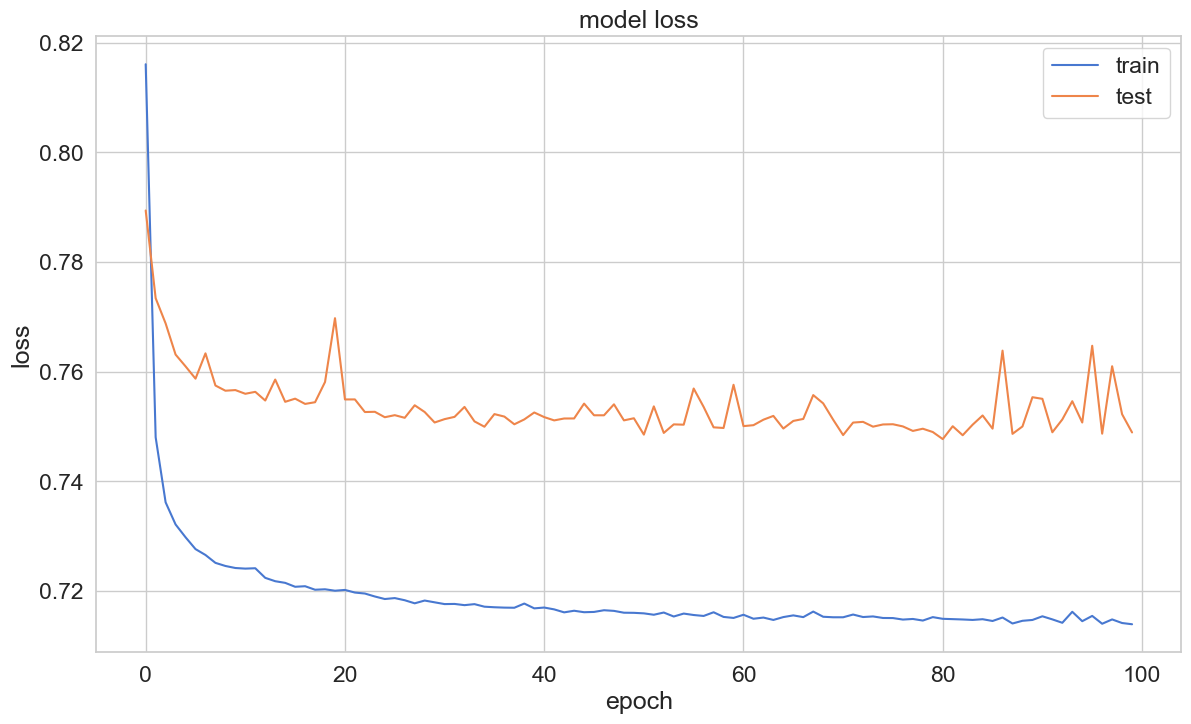

In [32]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [33]:
predictions = autoencoder.predict(X_test)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step


In [34]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [35]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.739177,0.001720
std,3.444716,0.041443
min,0.042846,0.000000
25%,0.249693,0.000000
50%,0.391911,0.000000
75%,0.614965,0.000000
max,270.122130,1.000000


# Reconstruction error without fraud

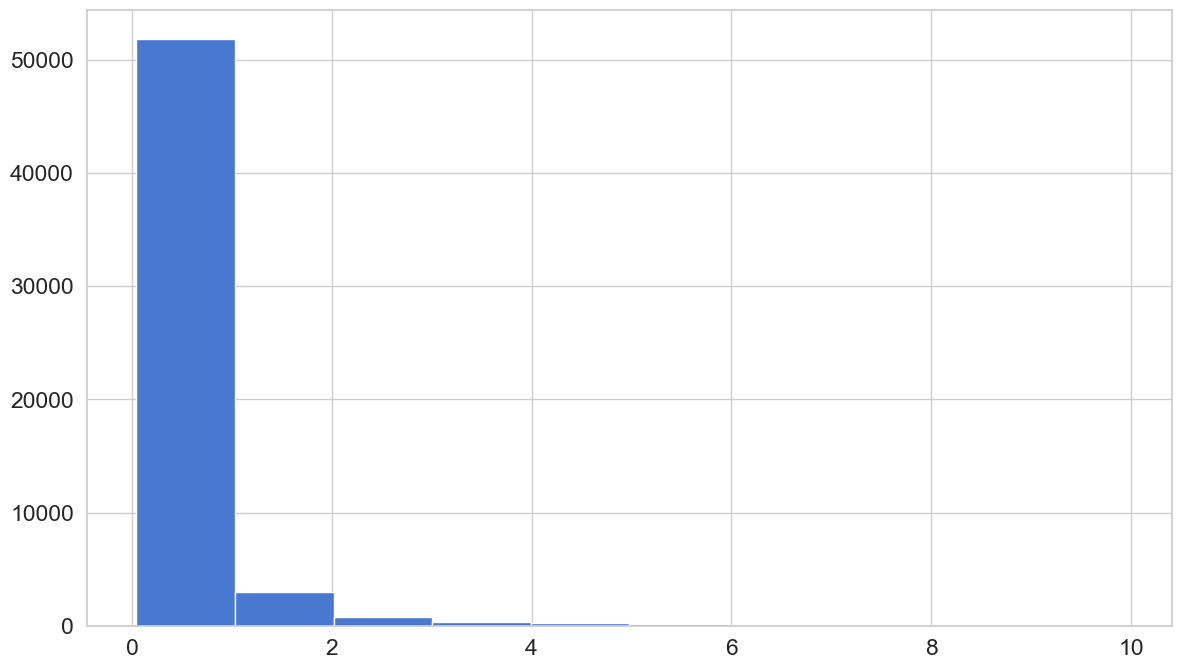

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

# Reconstruction error with fraud

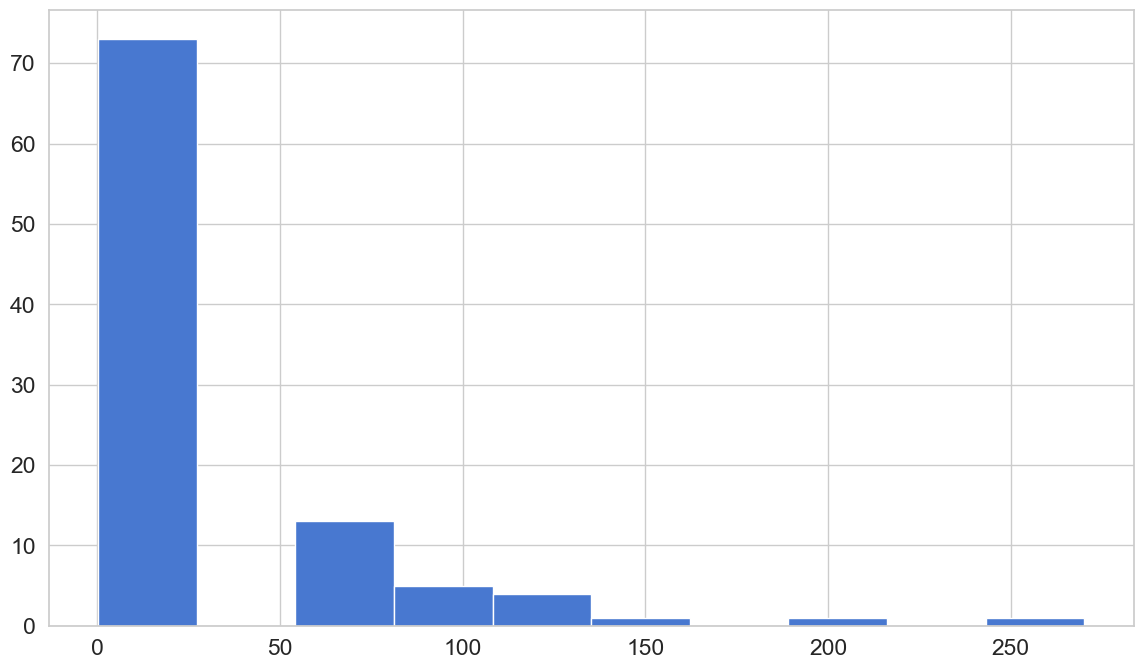

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [38]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let's have a look at our ROC curve:

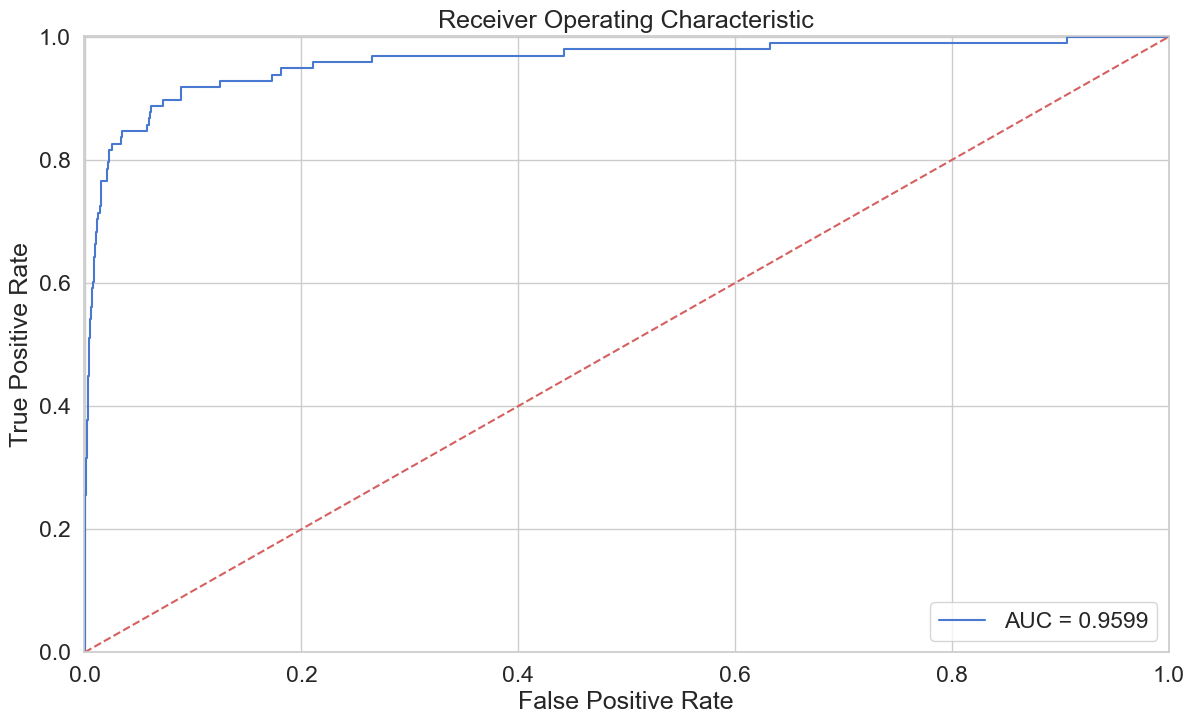

In [39]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

The ROC curve plots the true positive rate versus the false positive rate, over different threshold values. Basically, we want the blue line to be as close as possible to the upper left corner. While our results look pretty good, we have to keep in mind of the nature of our dataset. ROC doesn't look very useful for us. Onward...

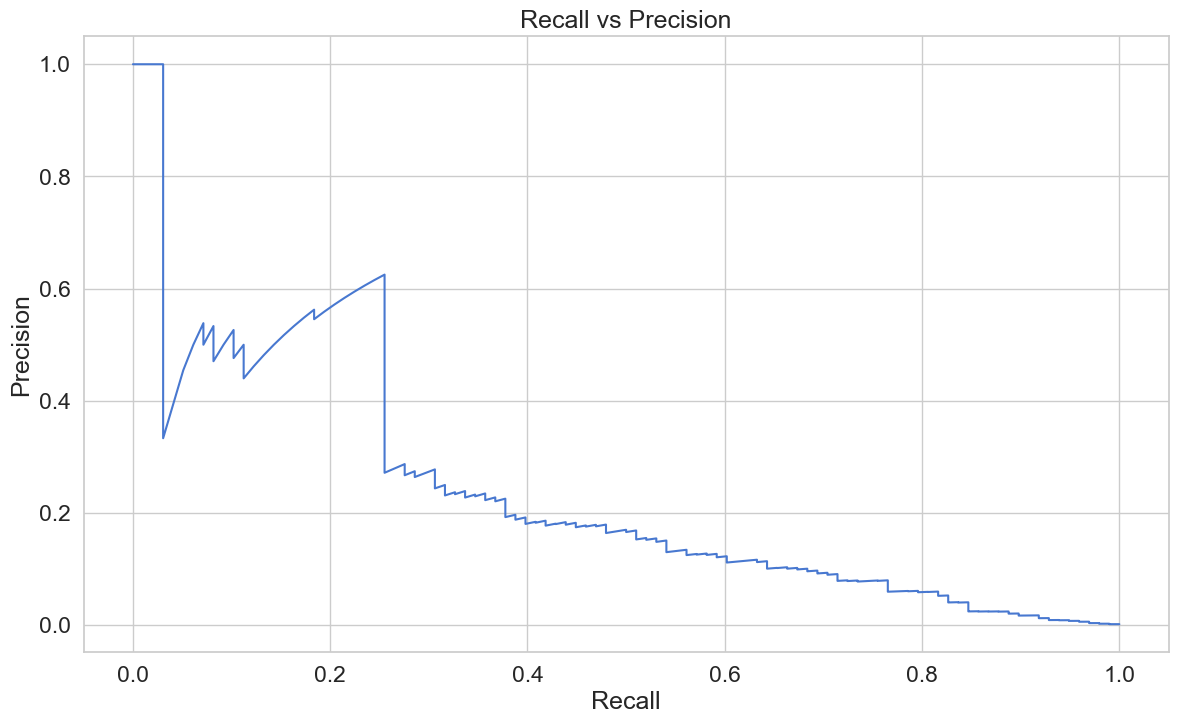

In [40]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

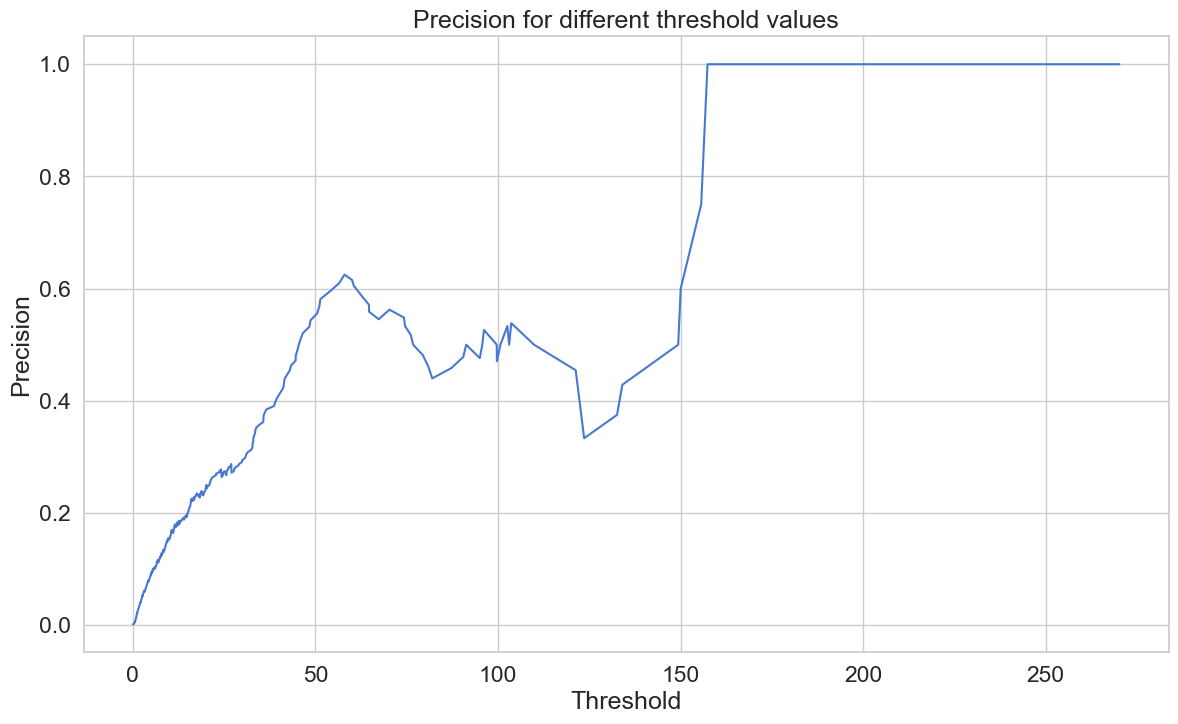

In [41]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

You can see that as the reconstruction error increases our precision rises as well. Let's have a look at the recall:

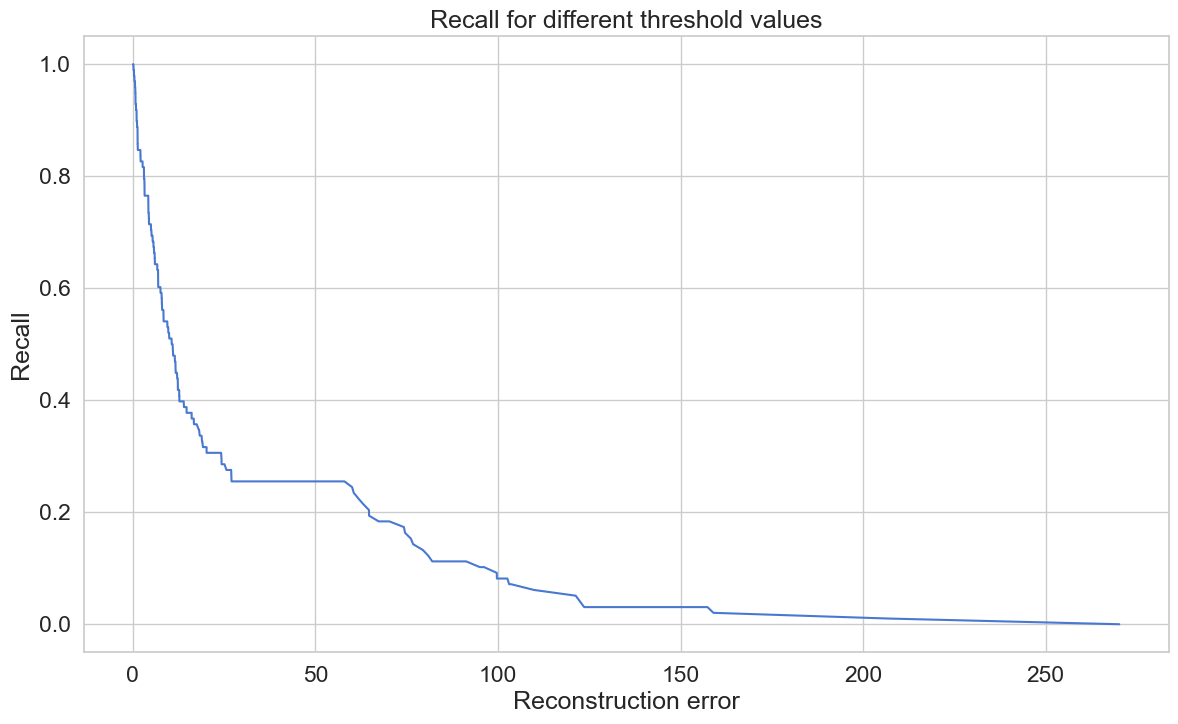

In [42]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

# Prediction

Our model is a bit different this time. It doesn't know how to predict new values. But we don't need that. In order to predict whether or not a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:

In [43]:
threshold = 2.9

And see how well we're dividing the two types of transactions:

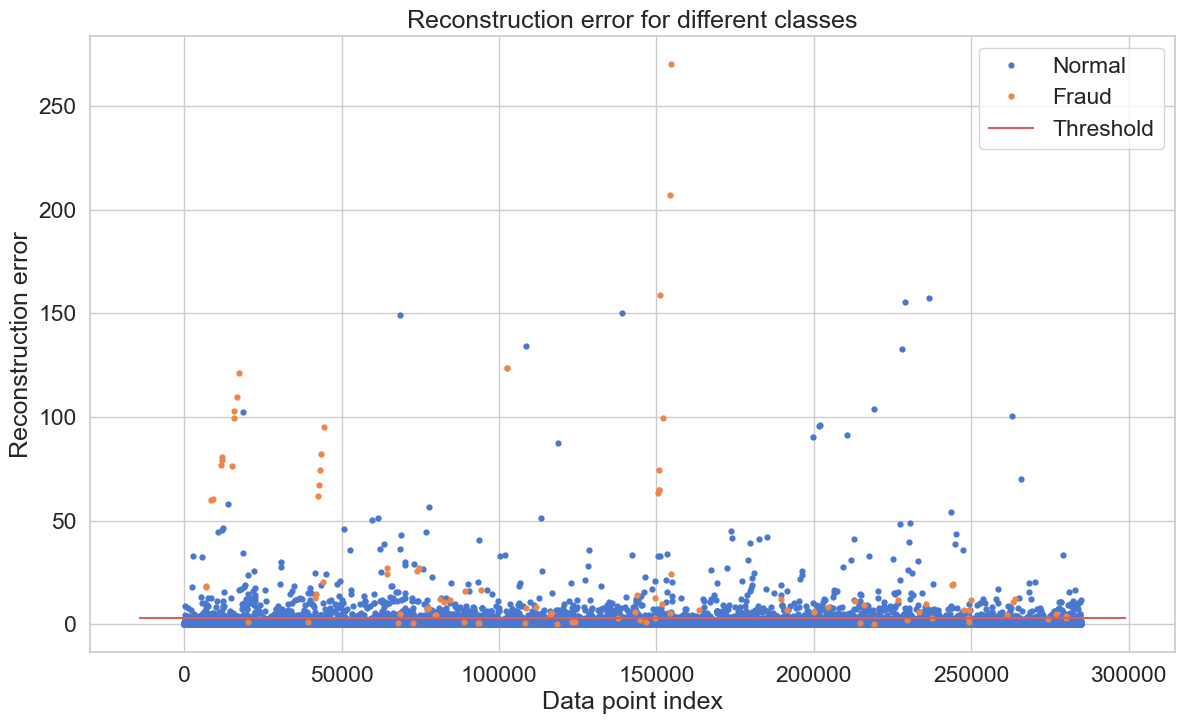

In [44]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

I know, that chart might be a bit deceiving. Let's have a look at the confusion matrix:

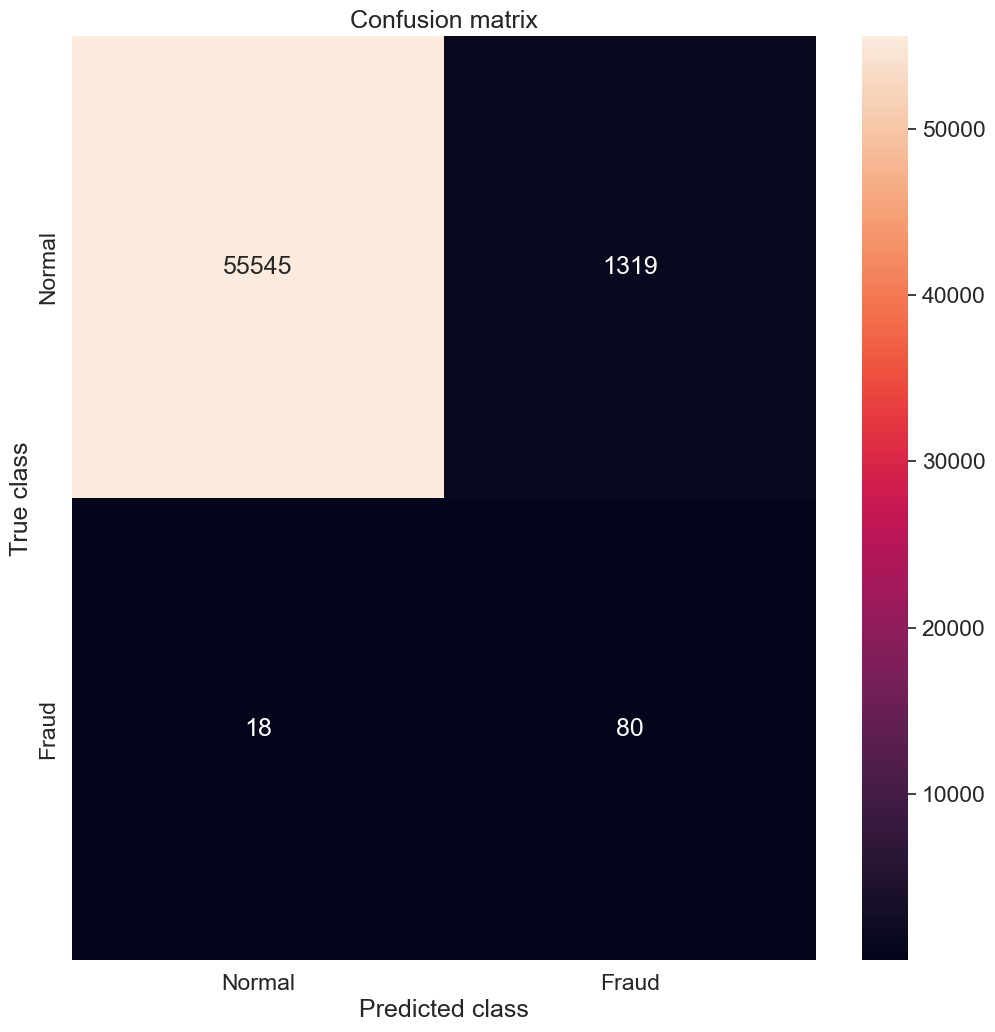

In [45]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Our model seems to catch a lot of the fraudulent cases. Of course, there is a catch (see what I did there?). The number of normal transactions classified as frauds is really high. Is this really a problem? Probably it is. You might want to increase or decrease the value of the threshold, depending on the problem. That one is up to you.

# Conclusion
We've created a very simple Deep Autoencoder in Keras that can reconstruct what non fraudulent transactions looks like. Initially, I was a bit skeptical about whether or not this whole thing is gonna work out, bit it kinda did. Think about it, we gave a lot of one-class examples (normal transactions) to a model and it learned (somewhat) how to discriminate whether or not new examples belong to that same class. Isn't that cool? Our dataset was kind of magical, though. We really don't know what the original features look like.

Keras gave us very clean and easy to use API to build a non-trivial Deep Autoencoder. You can search for TensorFlow implementations and see for yourself how much boilerplate you need in order to train one. Can you apply a similar model to a different problem?